In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import functools
import math
import scipy
from scipy.integrate import solve_ivp
from scipy.stats import norm

# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, build_cov_mat, lognormpdf, plot_bivariate_gauss, eval_func_on_grid

def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

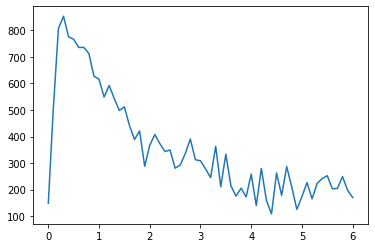

In [21]:
S0 = 900
I0 = 100
R0 = 0
x0 = [S0, I0, R0]

gamma = 0.2
k = 0.1
r = 0.6
delta = 0.15

N = 1000

t_span = np.linspace(0,6,61)

theta_vals = np.array([0.2, 0.1, 0.6, 0.15])

def SIRmodel_init(t, x):
    S, I, R = x
    gamma, k, r, delta = theta_vals
    return [delta*N-delta*S-gamma*k*I*S, gamma*k*I*S-(r+delta)*I, r*I - delta*R]
    
sol = scipy.integrate.solve_ivp(SIRmodel_init, [0, 6], x0, t_eval = t_span)

S=sol.y[0,:]
I=sol.y[1,:]
R=sol.y[2,:]

sigma = 50

Inoise=I
for ii in range(len(S)):
    Inoise[ii] = I[ii]+sigma*np.random.randn(1)

plt.plot(sol.t,Inoise)

In [22]:
def logmultivargaussianPDF(x,y,cov):
        logpdf = np.log(np.exp(-0.5*np.dot((x-y).T,np.dot(np.linalg.inv(cov),(x-y))))*1/(np.sqrt((2*np.pi)**2*np.linalg.det(cov)))) 
        return logpdf

In [23]:
class DelayedRejectionAdaptiveMetropolis:

    def __init__(self, logpdf, cov, k0=1000, freq=10, sd=None, max_samples=10000, eps=1e-7):
        """The class constructor, parameters are documented below"""
        self.logpdf = logpdf # callable (param) -> logpdf defining the logpdf
        self.cov = cov # initial covariance
        self.cov_chol = np.linalg.cholesky(cov) # sqrt of the covariance
        self.dim = cov.shape[0] # number of parameters
        self.k0 = k0 # time to start adapting
        self.freq = freq # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd # scale for the covariance                    
        self.max_samples = max_samples # maximum number of samples
        self.eps = eps # nugget for ensuring positive definite
        self.num_samples = 0 # number of samples generated
        self.samples = np.zeros((max_samples, self.dim)) # store the samples
        self.logpdf_vals = np.zeros((max_samples))
       
    def sample(self, initial_sample, num_samples):
   
        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"
       
        self.samples[0, :] = initial_sample
        self.logpdf_vals[0] = self.logpdf(initial_sample)
       
        accept = 0
        
        self.sample_mean = initial_sample
        for ii in range(1, num_samples):
           
            # propose
            y = self.samples[ii-1, :] + np.dot(self.cov_chol, np.random.randn(self.dim))
            y_logpdf = self.logpdf(y)
           
            # compute accept-reject probability, using the fact that we have a symmetric proposal
            a = np.exp(y_logpdf - self.logpdf_vals[ii-1])
            a = min(a, 1)
   
            u = np.random.rand()
           
            if u < a: #accept
                self.samples[ii, :] = y
                self.logpdf_vals[ii] = y_logpdf
                accept += 1
            else:
                # propose
                chollev2 = np.linalg.cholesky(0.1*self.cov) # sqrt of the covariance
                y2 = self.samples[ii-1, :] + np.dot(chollev2, np.random.randn(self.dim))
                y_logpdf2 = self.logpdf(y2)
                
                a1y2y1 = np.exp(y_logpdf-y_logpdf2)
                a1xy1 = np.exp(y_logpdf - self.logpdf_vals[ii-1])
                
                qterm1 = logmultivargaussianPDF(y,y2,self.cov)
                qterm2 = logmultivargaussianPDF(y,self.samples[ii-1, :],self.cov)
                
                a2 = np.exp((y_logpdf2+np.log(1-a1y2y1)+qterm1)-(self.logpdf_vals[ii-1]+np.log(1-a1xy1)+qterm2))
                a2 = min(a2,1)
                
                u2 = np.random.rand()

                if u2 < a2: # accept
                    self.samples[ii, :] = y2
                    self.logpdf_vals[ii] = y_logpdf2
                    accept += 1
                else:
                    self.samples[ii, :] = self.samples[ii-1, :]
                    self.logpdf_vals[ii] = self.logpdf_vals[ii-1]
                    
            if ii > self.k0 and ii % self.freq:
                
                sample_mean_new = (1/(ii+1))*self.samples[ii, :] + (ii/(ii+1))*self.sample_mean
               
                update_term = self.eps*np.eye(self.dim) + ii*np.dot(self.sample_mean,self.sample_mean) - (ii+1)*np.dot(sample_mean_new,sample_mean_new) + np.dot(self.samples[ii, :],self.samples[ii, :])
                self.cov = (ii-1)*self.cov/ii + self.sd*update_term/ii
               
                self.sample_mean = sample_mean_new
                self.chol_cov = np.linalg.cholesky(self.cov)
               
            self.num_samples += 1
               
            if ii % 10 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {accept / self.num_samples}")
               
        return self.samples

In [30]:
def logpdf_SIR(theta):

    def SIRmodel(t, x):
        S, I, R = x
        N=1000
        gamma, k, r, delta = theta
        return [delta*N-delta*S-gamma*k*I*S, gamma*k*I*S-(r+delta)*I, r*I - delta*R]
    
    sol = scipy.integrate.solve_ivp(SIRmodel, [0, 6], [900, 100, 0], t_eval = np.linspace(0,6,61))
    
    ypdf = np.zeros(len(sol.y[1,:]))
    tpdf = np.zeros(4)
    
    if theta[0] >= 0 and theta[1] >= 0 and theta[2] >= 0 and theta[3] >= 0:
        for ii in range(len(sol.y[1,:])):
             ypdf[ii] = np.log(norm.pdf(sol.y[1,ii],Inoise[ii], 50))
             #ypdf[ii] = np.log((1/(50*np.sqrt(2*np.pi)))*np.exp((-1/2)*np.square((Inoise[ii] - sol.y[1,ii])/50)))
            
        for jj in range(4):
             tpdf[jj] = np.log(norm.pdf(theta[jj],0,1))
        
        #print(ypdf)
        return np.sum(tpdf) + np.sum(ypdf)
    else:
        return -np.inf

In [31]:
def laplace_approx(initial_guess, logpost):
    """ Perform the laplace approximation
    
    Inputs
    -------
    initial_guess: (p, ) array of parameter guesses
    logpost: callable (p) to a scalar, denoting the posterior
    
    Output
    ------
    map_point: (p, )
    covariance: inverse hessian    
    """
    
    def neglogpost(params):
        return -logpost(params)
    
    # Gradient free method to obtain close to optimum
    res = scipy.optimize.minimize(neglogpost, initial_guess, method='Nelder-Mead')
    
    # Gradient based method to approximate hessian
    res = scipy.optimize.minimize(neglogpost, res.x)
    
    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx

In [32]:
num_samples = 5000
cov_initial = np.diag(np.array([2e-4, 1e-3, 1e-3]))
theta_initial = np.array([0.2, 0.1, 0.6, 0.15])
initial_sample = [0.1,0.1,0.1,0.1]
mappoint, cov_initial = laplace_approx(initial_sample,logpdf_SIR)
print(cov_initial)
cov_initial = np.array([[3.13e-06, -1.3e-05, -3.9e-06, -3.9e-06],[-1.3e-05, 5.6e-04,1.6e-04, -3.9e-06],[-3.9e-06,1.6e-04,9.1e-05, -3.9e-06],[-1.3e-05, 5.6e-04,1.6e-04, -3.9e-06]])
print(cov_initial)
dram = DelayedRejectionAdaptiveMetropolis(logpdf_SIR, cov_initial, freq=5, k0=300, sd=2.38**2/3, eps=1e-7, max_samples=num_samples)
samples = dram.sample(mappoint,num_samples)

[[ 0.18521326 -0.18441114 -0.00033247 -0.00020743]
 [-0.18441114  0.18379033  0.00030987  0.00019099]
 [-0.00033247  0.00030987  0.00062301  0.0003493 ]
 [-0.00020743  0.00019099  0.0003493   0.00028967]]
[[ 3.13e-06 -1.30e-05 -3.90e-06 -3.90e-06]
 [-1.30e-05  5.60e-04  1.60e-04 -3.90e-06]
 [-3.90e-06  1.60e-04  9.10e-05 -3.90e-06]
 [-1.30e-05  5.60e-04  1.60e-04 -3.90e-06]]


LinAlgError: Matrix is not positive definite

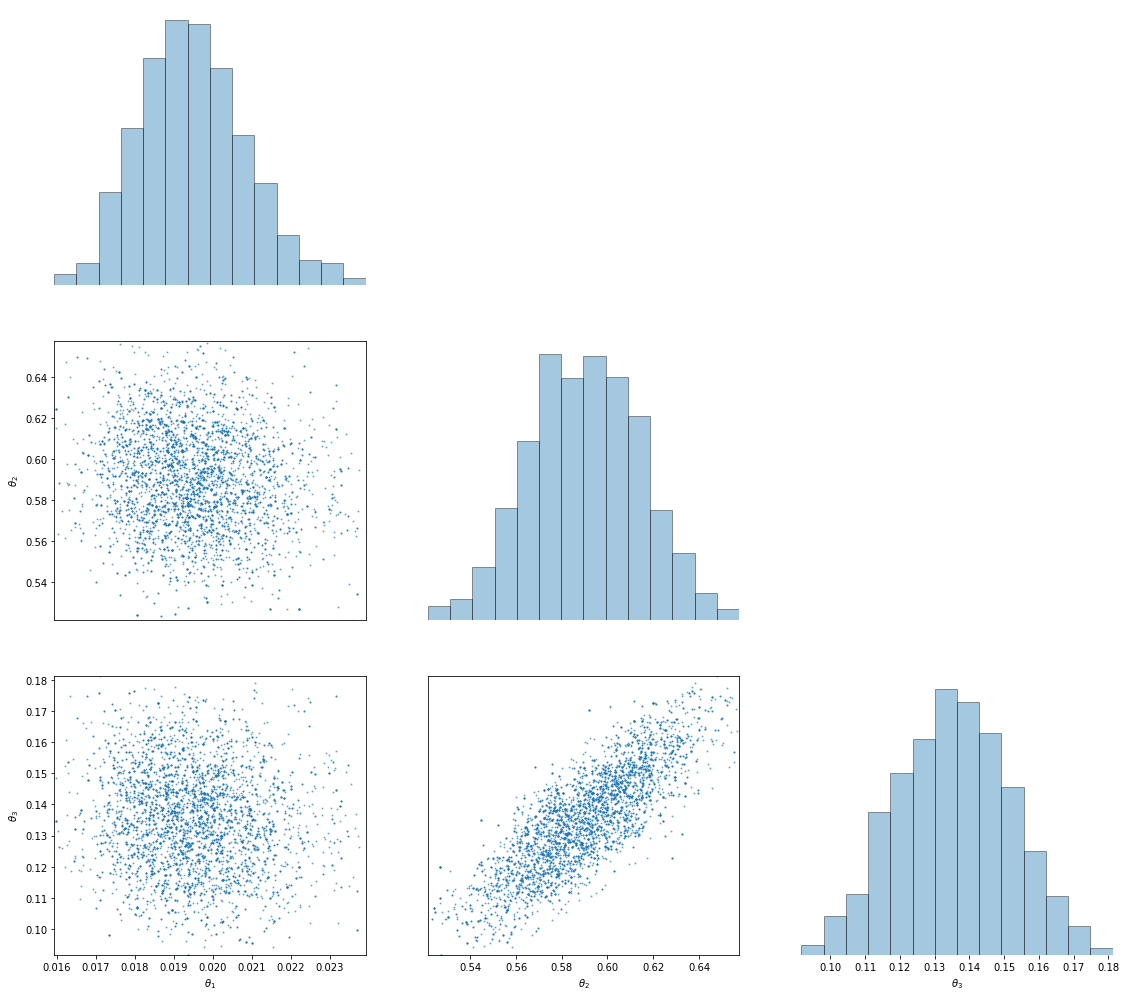

In [33]:
fig, axs, gs = scatter_matrix([samples], hist_plot=False, gamma=0.5, labels=[r'$\theta_1$', r'$\theta_2$', r'$\theta_3$'])
fig.set_size_inches(15,15)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.2, hspace=0.2)


In [11]:
def autocorrelation(samples, maxlag=500, step=1):
    """Compute the correlation of a set of samples
    
    Inputs
    ------
    samples: (N, d)
    maxlag: maximum distance to compute the correlation for
    step: step between distances from 0 to maxlag for which to compute teh correlations
    """
    
    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]    
    
    # Compute the mean
    mean = np.mean(samples, axis=0)
    
    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2
    
    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

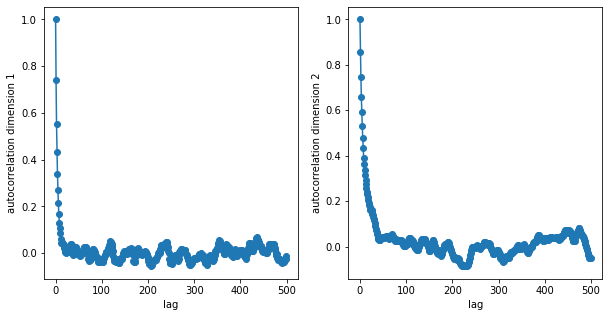

8.451403944052835
27.61644677501492


In [16]:
maxlag=500
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation dimension 1')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation dimension 2')
plt.show()

IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)

Text(0.5, 0, 'Sample Number')

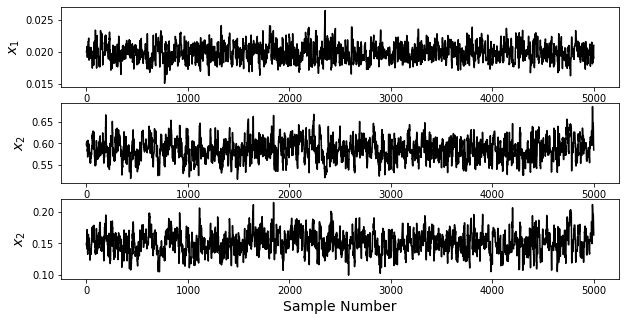

In [15]:
fig, axs = plt.subplots(3,1, figsize=(10,5))
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$x_1$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$x_2$', fontsize=14)
axs[1].set_xlabel('Sample Number', fontsize=14)
axs[2].plot(samples[:, 2], '-k')
axs[2].set_ylabel(r'$x_2$', fontsize=14)
axs[2].set_xlabel('Sample Number', fontsize=14)
#axs[1].set_xlim([40000, 50000])

In [17]:
def autocorrelation(samples, maxlag=100, step=1):
    """Compute the correlation of a set of samples
    
    Inputs
    ------
    samples: (N, d)
    maxlag: maximum distance to compute the correlation for
    step: step between distances from 0 to maxlag for which to compute teh correlations
    """
    
    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]    
    
    # Compute the mean
    mean = np.mean(samples, axis=0)
    
    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2
    
    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

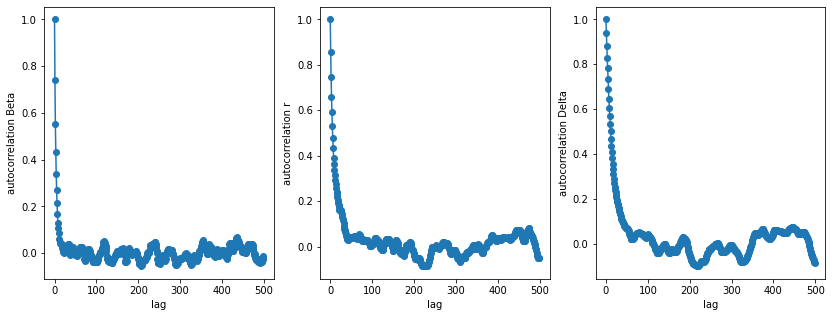

8.451403944052835
27.61644677501492
34.285936771902385


In [18]:
maxlag=500
step=1
lags, autolag = autocorrelation(samples, maxlag=maxlag,step=step)
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].plot(lags, autolag[:, 0],'-o')
axs[0].set_xlabel('lag')
axs[0].set_ylabel('autocorrelation Beta')
axs[1].plot(lags, autolag[:, 1],'-o')
axs[1].set_xlabel('lag')
axs[1].set_ylabel('autocorrelation r')
axs[2].plot(lags, autolag[:, 2],'-o')
axs[2].set_xlabel('lag')
axs[2].set_ylabel('autocorrelation Delta')
plt.show()
IAC1 = 1+2*np.sum(autolag[:,0])
print(IAC1)
IAC2 = 1+2*np.sum(autolag[:,1])
print(IAC2)
IAC3 = 1+2*np.sum(autolag[:,2])
print(IAC3)

In [25]:
print(np.mean(samples,0))

[0.01987426 0.58598127 0.15159749]


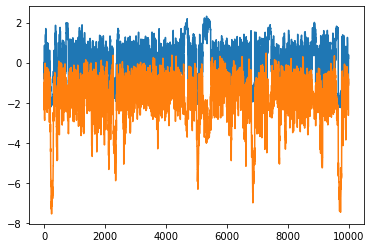

In [87]:
plt.plot(samples)

In [14]:
print(np.min(autolag))

-0.10697087739912714
